In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('cohort_raw.csv')
data.head(2)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate
0,262,1/11/09,47,50.67,TRQKD,2,1/12/09
1,278,1/20/09,47,26.60,4HH2S,3,1/20/09


In [8]:
data.shape

(732, 8)

In [3]:
# change two date columns to the date data format
data['OrderDate'] = pd.to_datetime(data['OrderDate'], errors = 'coerce')
data['PickupDate'] = pd.to_datetime(data['PickupDate'], errors = 'coerce')


In [4]:
first_order = data.groupby('UserId')['OrderDate'].min().dt.strftime("%Y-%m").reset_index()
first_order.columns = ['UserId','CohortGroup']
first_order[:3]


,UserId,CohortGroup
0,47,2009-01
1,95,2009-03
2,98,2009-01


In [5]:
# create a new column for each order's date
data['OrderPeriod'] = data['OrderDate'].dt.strftime('%Y-%m')

In [6]:
data = pd.merge(data, first_order, on = 'UserId'
                , how = 'inner' )
data.head(2)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01


- create a new column to know the difference between OrderPeriod and CohortGroup in months
 named as CohortPeriod (1, 2,3,..)

In [13]:
data.head(4)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01


In [7]:
from datetime import datetime 

In [8]:
# first convert OrderPeriod and CohortGroup as date type
end = pd.to_datetime(data['OrderPeriod'])
start = pd.to_datetime(data['CohortGroup'])
diff = end.sub(start, axis = 0) # get difference now as 0 days
diff = np.round(diff / np.timedelta64(1, 'M')) + 1 # the same date will start from 1
diff = diff.astype(int)
diff[:4]

0    1
1    1
2    2
3    2
dtype: int64

In [9]:
final = pd.concat([data, diff], axis = 1)
final['CohortPeriod']= final[0]

final.head(2)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup,0,CohortPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01,1,1
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01,1,1


In [10]:
final.drop(0, axis = 1, inplace = True)
final.head(2)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup,CohortPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01,1
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01,1


In [11]:
final.head(8)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup,CohortPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01,1
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01,1
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02,2009-01,2
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01,2
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02,2009-01,2
5,321,2009-02-17,47,29.50,HA5R3,3,2009-02-17,2009-02,2009-01,2
6,333,2009-02-23,47,18.91,RSXQG,2,2009-02-23,2009-02,2009-01,2
7,341,2009-03-01,47,64.41,KHBDJ,3,2009-03-03,2009-03,2009-01,3


# Cohort analysis

In [12]:
grouped = final.groupby(['CohortGroup','OrderPeriod'])

In [13]:
cohorts = grouped.agg({ 'Order Id': 'nunique',
                       'UserId':'nunique',
                       'Total Charges': 'sum',
                       'CohortPeriod': 'min'
})

In [14]:
cohorts[:3]

Total Charges  CohortPeriod  UserId  Order Id
CohortGroup OrderPeriod                                               
2009-01     2009-01           1850.255             1      22        30
            2009-02           1351.065             2       8        25
            2009-03           1357.360             3      10        26

In [15]:
cohorts.reset_index(inplace = True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

In [16]:
cohorts[:7]

OrderPeriod  Total Charges  UserId  Order Id
CohortGroup CohortPeriod                                             
2009-01     1                2009-01       1850.255      22        30
            2                2009-02       1351.065       8        25
            3                2009-03       1357.360      10        26
            4                2009-04       1604.500       9        28
            5                2009-05       1575.625      10        26
            6                2009-06       1384.840       8        26
            7                2009-07       1750.840       8        24

In [17]:
cohorts.columns = ['OrderPeriod','TotalCharges','TotalUser','TotalOrder']

In [18]:
a = cohorts.reset_index()
np.unique(a['CohortGroup'])

array([u'2009-01', u'2009-02', u'2009-03', u'2009-04', u'2009-05',
       u'2009-12', u'2010-01', u'2010-02'], dtype=object)

In [19]:
# Now focus on User's trend
user = cohorts['TotalUser'].unstack('CohortGroup')
user.head(3)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-12,2010-01,2010-02
CohortPeriod,,,,,,,,
1,22.0,15.0,13.0,19.0,8.0,1.0,1.0,2.0
2,8.0,3.0,4.0,8.0,2.0,1.0,NaN,NaN
3,10.0,5.0,5.0,6.0,1.0,NaN,NaN,NaN


In [20]:
user_first = user.loc[1]
user_first

CohortGroup
2009-01    22.0
2009-02    15.0
2009-03    13.0
2009-04    19.0
2009-05     8.0
2009-12     1.0
2010-01     1.0
2010-02     2.0
Name: 1, dtype: float64

In [21]:
user_retention = user/user_first
user_retention[:3]

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-12,2010-01,2010-02
CohortPeriod,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000,1.0,1.0,1.0
2,0.363636,0.200000,0.307692,0.421053,0.250,1.0,NaN,NaN
3,0.454545,0.333333,0.384615,0.315789,0.125,NaN,NaN,NaN


In [22]:
# make some plots

user1 = user_retention[['2009-01','2009-02','2009-03']]


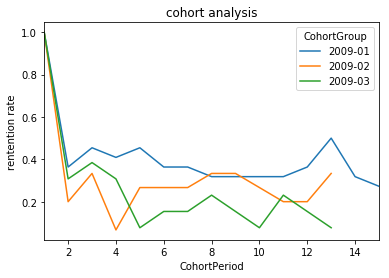

In [23]:
user1.plot()
plt.title('cohort analysis')
plt.ylabel('rentention rate')
plt.show()

In [50]:
user1.head(2)

CohortGroup,2009-01,2009-02,2009-03
CohortPeriod,,,
1,1.000000,1.0,1.000000
2,0.363636,0.2,0.307692


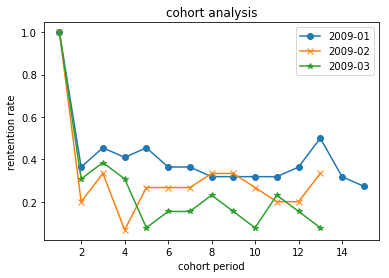

In [24]:
plt.plot(user1.index, user1['2009-01'], label = '2009-01', marker = 'o')
plt.plot(user1.index, user1['2009-02'], label = '2009-02', marker = 'x')
plt.plot(user1.index, user1['2009-03'], label = '2009-03', marker = '*')
plt.legend()
plt.title('cohort analysis')
plt.ylabel('rentention rate')
plt.xlabel('cohort period')
plt.show()

In [25]:
retention_t = user_retention.T
retention_t.head(2)

CohortPeriod,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
CohortGroup,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,NaN,NaN


In [26]:
retention_t.index, retention_t.columns

(Index([u'2009-01', u'2009-02', u'2009-03', u'2009-04', u'2009-05', u'2009-12',
        u'2010-01', u'2010-02'],
       dtype='object', name=u'CohortGroup'),
 Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name=u'CohortPeriod'))

In [27]:
import seaborn as sns

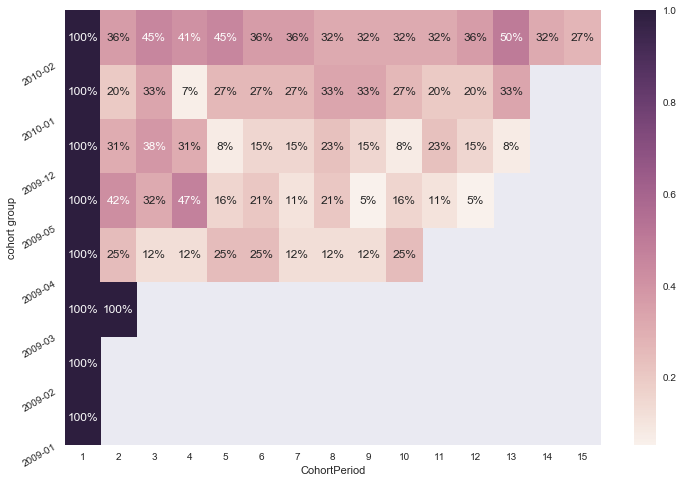

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_t,
             mask=retention_t.isnull(), annot=True, fmt='.0%')
plt.ylabel('cohort group')
x = range(len(retention_t.index))
plt.yticks(x, retention_t.index, rotation = 30)
plt.show()

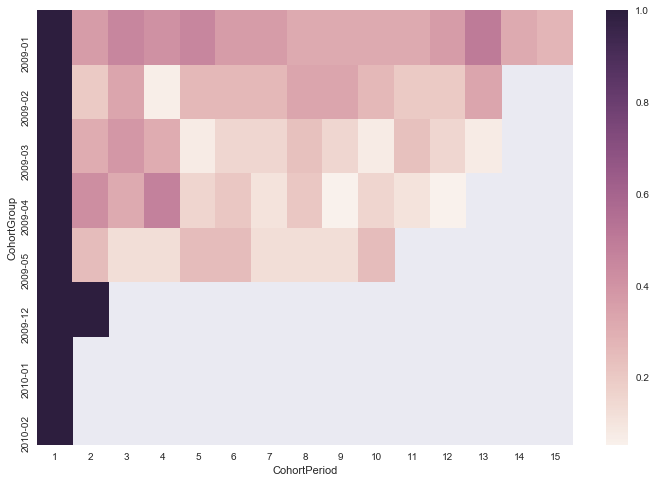

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_t,
            yticklabels= retention_t.index.values, # has to add.values
            xticklabels = retention_t.columns.values
           ,fmt = '.0%')

plt.show()

In [ ]:
# Retention Rate

In [32]:
final.head(2)

,Order Id,OrderDate,UserId,Total Charges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup,CohortPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01,2009-01,1
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01,2009-01,1


In [33]:
grouped2 = final.groupby('CohortPeriod')

In [35]:
retention = grouped2.agg({'UserId': 'nunique',
                         'Total Charges': 'sum'})
retention.head(3)

,Total Charges,UserId
CohortPeriod,,
1,6187.4105,81
2,3349.9350,26
3,4290.6900,27


In [39]:
initial = retention.loc[1]['UserId']
initial

81.0

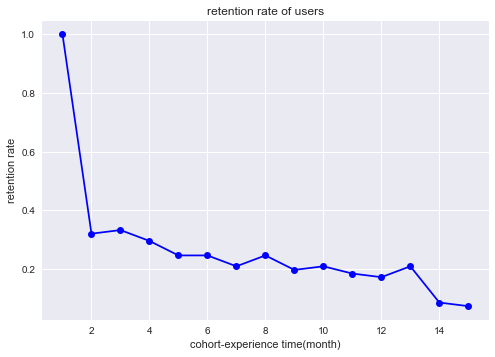

In [47]:
retention_rate = retention['UserId']/initial
plt.plot(retention_rate.index, retention_rate, marker = 'o', color = 'blue')
plt.title('retention rate of users')
plt.xlabel('cohort-experience time(month)')
plt.ylabel('retention rate')
plt.show()

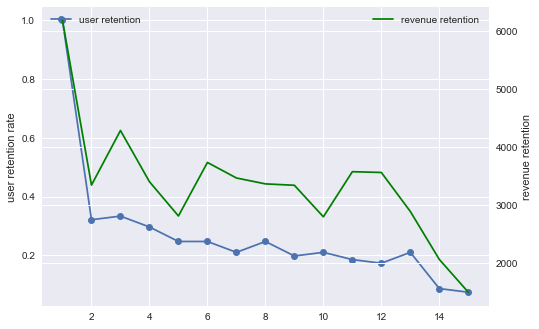

In [54]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(retention_rate.index, retention_rate, marker = 'o',
         label = 'user retention')
ax1.set_ylabel('user retention rate')
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
ax2.plot(retention.index, retention['Total Charges'], label = 'revenue retention', color = 'green')
ax2.set_ylabel('revenue retention')
ax2.legend(loc = 'best')

plt.show()